# Intraday Resistance Breakout

In my version of Resistance Breakout, I implemented a 20-period rolling assessment of maximum and minimum price points. Within this framework, strategic positions will be initiated or liquidated contingent upon surpassing the established the resistance or dipping beneath the support. Furthermore, the delineation of our stop-loss directive is based on the previous day's closing price +/- the magnitude of the 20-period Average True Range (ATR), effectively serving as the dynamic threshold for our rolling stop-loss.

To access the efficacy of our strategy, we will backtest over a span of 2 months (maximum intraday data allowed by yfinance), employing historical stock data.

The evaluation of our strategy's performance will be based on the following quantitative finance metrics:
1. <strong>Compounded Annual Growth Rate (CAGR):</strong> This metric will gauge the annualized return achieved by our assets, expressing the growth in their market value from the initial investment. Since the candlestick size is drastically smaller in intraday trading, CAGR does not 
2. <strong>Sharpe Ratio:</strong> By employing the Sharpe Ratio, we can measure the risk-adjusted relative returns of our equity, effectively comparing its performance to that of a 'theoretical' risk-free investment, exemplified by U.S. government treasury bonds.
3. <strong>Maximum Drawdown:</strong> A paramount indicator of downside risk over our designated time horizon, Maximum Drawdown concentrates on the most substantial percentage decline experienced by our asset's price. 

Here are various formulas used in our backtesting:

$$CAGR = \left[ {v_f } \over { v_i} \right]^{1 \over t} - 1$$
$v_i =$ Initial Value<br/>
$v_f =$ Final Value<br/>
$t =$ Time (years)<br/>

$$Sharpe \space Ratio = {{R_p - R_f} \over \sigma_p}$$
$R_p =$ Expected Returns <br />
$R_f =$ Risk Free rate of return <br />
$\sigma_p =$ Standard Deviation of Asset Returns<br /><br />

Note that we will use 3.9% as the risk-free investment rate of return, as it has been the average for the U.S. Treasury Bond for the past 10 years. 

************************ OVERALL STRATEGY PERFORMANCE INDICATORS *************************
Strategy CAGR: 0.27157038564631275
Strategy Sharpe Ratio: 5.243997871995073
Strategy Max Drawdown: 0.008250726302957642


************************ STRATEGY PERFORMANCE INDICATORS (by stock) *************************
                                    AAPL      GOOG      AMZN      NFLX  \
Compounded Average Growth Rate  0.137889  0.505708 -0.010935  0.324502   
Sharpe Ratio                    1.707086  5.246623 -0.530290  3.513974   
Max Drawdown                    0.015687  0.019727  0.035473  0.012834   

                                    META      NVDA       AMD      MSFT  \
Compounded Average Growth Rate  0.141336  0.298637  0.304349  1.006997   
Sharpe Ratio                    1.049987  1.939656  2.052899  7.360666   
Max Drawdown                    0.036477  0.044842  0.040775  0.012071   

                                     IBM      TSLA      INTC      PLTR  \
Compounded Average Growth

<Axes: xlabel='Datetime'>

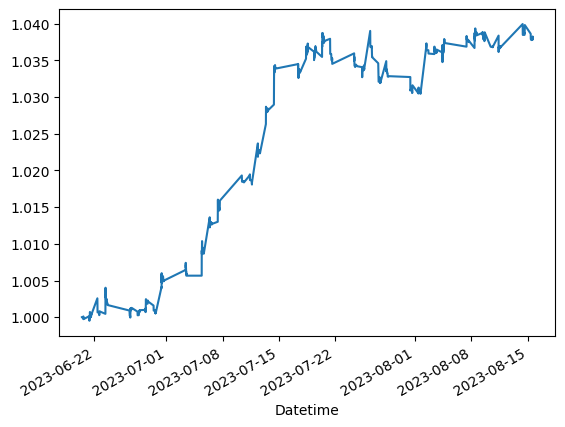

In [5]:
# -------------------------------------------------------------------------------
# Author: Daniel Xu
# Date: 08/14/2023
# Description: Backtesting for Intraday Resistance Breakout strategy
# -------------------------------------------------------------------------------

import yfinance as yf
import numpy as np
import pandas as pd
import copy
import datetime as dt

################################# FUNCTION DEFINITIONS ###################################

# ATR - Given a DataFrame, returns Average True Range. Takes in a window
#   variable used to calculate Rolling Average'
def ATR(df, window):
    df_copy = df.copy()
    df_copy['High-Low'] = df_copy['High'] - df_copy['Low']
    df_copy['High-PC'] = df_copy['High'] - df['Close'].shift(1) # shift to PREVIOUS close
    df_copy['Low-PC'] = df_copy['Low'] - df['Adj Close'].shift(1)
    df_copy['True Range'] = df_copy[['High-Low', 'High-PC', 'Low-PC']].max(axis=1, skipna=False)
    
    # Using 'com' instead of 'span' will get us closer to yfinance's Exponential Moving Average
    #   'span' is closer to TradingView's algorithm for EMA
    df_copy['ATR'] = df_copy['True Range'].ewm(span=window, min_periods=window).mean()
    return df_copy['ATR']

# CAGR - takes in a DataFrame and computes the Compounded Average Growth Rate
def cagr(df):
    temp = df.copy()
    temp['Cumulative Returns'] = (1 + temp['Return']).cumprod()
    # decimal expression of years, based on number of 5 minute candles, thus multiply the approx. number of trading days
    #   with the number of 5 min candles (78)
    n = len(temp)/(252*78)
    CAGR = (temp['Cumulative Returns'][-1])**(1/n) - 1
    return CAGR

# MAX_DRAWDOWN - returns the maximum drawdown of a 7 month period of our analyzed stocks
def max_drawdown(df):
    temp = df.copy()
    temp['Cumulative Return'] = (1 + temp['Return']).cumprod()
    temp['Cumulative Rolling Max'] = temp['Cumulative Return'].cummax()
    temp['Drawdown'] = temp['Cumulative Rolling Max'] - temp['Cumulative Return']
    md = (temp['Drawdown'] / temp['Cumulative Rolling Max']).max()
    return md

# VOLATILITY - calculates the annualized volatility of a trading strategy
def volatility(df):
    temp = df.copy()
    vty = temp['Return'].std() * np.sqrt(252*78)
    return vty

# SHARPE - takes in DataFrame and Risk Free Rate of Return, returns sharpe ratio
def sharpe(df, rfr):
    shp = (cagr(df) - rfr) / volatility(df)
    return shp

################################# DOWNLOAD HISTORICAL DATA ###################################

tickers = [ 'AAPL', 'GOOG', 'AMZN', 'NFLX', 'META', 'NVDA', 'AMD', 'MSFT', 'IBM', 'TSLA', 'INTC', 'PLTR', 'SHOP']

intraday_stock_data = {}
buy_hold_data = {}
start_time = dt.datetime.today() - dt.timedelta(59)
end_time = dt.datetime.today()

for t in tickers:
    data = yf.download(t, start_time, end_time, interval='5m', progress=False) # 5 minute candles
    data.dropna(how='any', inplace=True)
    intraday_stock_data[t] = data
    buy_hold_data[t] = yf.download(t, start_time, end_time, interval='1d', progress=False)


################################# BACKTESTING ###################################

test_data = copy.deepcopy(intraday_stock_data)
# signal stores: buy/sell signal for stocks wrt particular candle
signal = {}
# calulate the return for stocks wrt particular candle
ret = {}

# Indicator calculations
for t in tickers: 
    test_data[t]['ATR'] = ATR(test_data[t], 20)
    test_data[t]['Rolling Max High'] = test_data[t]['High'].rolling(20).max()
    test_data[t]['Rolling Min Low'] = test_data[t]['Low'].rolling(20).min()
    test_data[t]['Rolling Max Volume'] = test_data[t]['Volume'].rolling(20).max()
    test_data[t]['Cumulative Return'] = test_data[t]['Adj Close'] - test_data[t]['Adj Close'].shift(-1)
    test_data[t].dropna(inplace=True)
    signal[t] = ''
    ret[t] = []

# Signal Identification & Return Calculations
for t in tickers:
    for i in range(0, len(test_data[t])):
        if signal[t] == '':
            ret[t].append(0)
            if test_data[t]['High'][i] >= test_data[t]['Rolling Max High'][i] and \
                test_data[t]['Volume'][i] > 1.5 * test_data[t]['Rolling Max Volume'][i-1]:
                    signal[t] = 'BUY'
            elif test_data[t]['Low'][i] <= test_data[t]['Rolling Min Low'][i] and \
                test_data[t]['Volume'][i] > 1.5 * test_data[t]['Rolling Max Volume'][i-1]:
                    signal[t] = 'SELL'
        elif signal[t] == 'BUY':
            # If stop loss has been hit
            if test_data[t]['Low'][i] < test_data[t]['Close'][i-1] - test_data[t]['ATR'][i-1]:
                signal[t] = ''
                ret[t].append(((test_data[t]['Close'][i-1] - test_data[t]['ATR'][i-1]) / test_data[t]['Close'][i-1]) - 1)
            # In the case of a reversal
            elif test_data[t]['Low'][i] <= test_data[t]['Rolling Min Low'][i] and \
                test_data[t]['Volume'][i] > 1.5 * test_data[t]['Rolling Max Volume'][i-1]:
                    signal[t] = 'SELL'
                    ret[t].append((test_data[t]['Close'][i] / test_data[t]['Close'][i-1]) - 1)
            else:
                ret[t].append((test_data[t]['Close'][i] / test_data[t]['Close'][i-1]) - 1)
        elif signal[t] == 'SELL':
            # If stop loss has been hit
            if test_data[t]['High'][i] > test_data[t]['Close'][i-1] + test_data[t]['ATR'][i-1]:
                signal[t] = ''
                ret[t].append((test_data[t]['Close'][i-1] / (test_data[t]['Close'][i-1] + test_data[t]['ATR'][i-1])) - 1)
            # In the case of a reversal
            elif test_data[t]['High'][i] >= test_data[t]['Rolling Max High'][i] and \
                test_data[t]['Volume'][i] > 1.5 * test_data[t]['Rolling Max Volume'][i-1]:
                    signal[t] = 'BUY'
                    ret[t].append((test_data[t]['Close'][i-1] / test_data[t]['Close'][i]) - 1)
            else:
                ret[t].append((test_data[t]['Close'][i-1] / test_data[t]['Close'][i]) - 1)
    
    test_data[t]['Return'] = np.array(ret[t])


################################# EVALUATION ###################################

strategy = pd.DataFrame()
for t in tickers:
    strategy[t] = test_data[t]['Return']
strategy['Return'] = strategy.mean(axis=1)
print('************************ OVERALL STRATEGY PERFORMANCE INDICATORS *************************')
print('Strategy CAGR:', cagr(strategy))
print('Strategy Sharpe Ratio:', sharpe(strategy, 0.039))
print('Strategy Max Drawdown:', max_drawdown(strategy))

################################# EVALUATION ###################################

# KPIs for strategy
cagr_dict = {}
sharpe_dict = {}
md_dict = {}

# Dictionary for print outputs (Buy and Hold)
buy_hold_growth = {}
# DataFrame for graphing
buy_hold = pd.DataFrame()

for t in tickers:
    cagr_dict[t] = cagr(test_data[t])
    sharpe_dict[t] = sharpe(test_data[t], 0.039)
    md_dict[t] = max_drawdown(test_data[t])
    buy_hold_growth[t] = (buy_hold_data[t]['Close'][-1] / buy_hold_data[t]['Open'][0]) - 1
    buy_hold[t] = (buy_hold_data[t]['Close'][-1] / buy_hold_data[t]['Open'][0]) - 1

print('\n\n************************ STRATEGY PERFORMANCE INDICATORS (by stock) *************************')

strategy_KPIs = pd.DataFrame([cagr_dict, sharpe_dict, md_dict], index=['Compounded Average Growth Rate', 'Sharpe Ratio', 'Max Drawdown'])
strategy_KPIs.T
print(strategy_KPIs)

print('\n\n************************ REGULAR BUY/HOLD RETURNS (by stock) *************************')

buy_hold_returns = pd.DataFrame([buy_hold_growth], index = ['Return'])
buy_hold_returns.T
print(buy_hold_returns)

################################# VISUALIZATION ###################################
print('\n\n************************ PERFORMANCE VISUALIZATIONS *************************')
(1 + strategy['Return']).cumprod().plot()



As seen in the graph, we achieve a mean growth of approximately 4% over two months of trading with Resistance Breakout. Although are backtesting data only spans 2 months, we can see that the growth rate of the stocks using our strategy are consistently higher than the growth rates of a regular buy/hold strategy, except for PLTR and AMZN. Sharpe Ratio varies based on the stock, but overall sits around 5.2, implying that our strategy outperforms the risk free return on investment by a good amount. Maximum drawdown isn't significant, as there is generally not much change that occurs within a 5 minute candlestick. 

Notably, over the last two months, TSLA stock has been tanking, but our strategy managed to obtain a 0.3+ CAGR. Contrarily, AMZN has been rising steadily, achieving an overall growth of 10% over the last 2 months, but our strategy reports a -0.01 CAGR. 

In summary, although our strategy is seen to perform well on our backtesting period, there is not nearly enough data for us to conclude its proficiency for live trading. There are various factors that have not been accounted for, such as slippage occuring from the assumption that orders will be filled at the close price of each candle and brokerage costs. More backtesting would, the incorporation of more technical/performance indicators, or machine learning techniques such as sentiment analysis could help improve the predictions and profibility of my version of the Intraday Resistance Breakout. 